# OCR in videos with Tesseract and EAST

# Importing the libraries

In [1]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
from imutils.object_detection import non_max_suppression
from PIL import Image
from PIL import ImageFont, ImageDraw, Image

# Tesseract

In [2]:
# !sudo apt install tesseract-ocr
# !pip install pytesseract
# !mkdir tessdata
# !wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true

In [3]:
import pytesseract

In [4]:
config_tesseract = "--tessdata-dir tessdata --psm 7"

In [5]:
def tesseract_OCR(img, config_tesseract):
  text = pytesseract.image_to_string(img, lang='por', config=config_tesseract)
  return text

# Pre-processing

In [6]:
def pre_processing(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  resized = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
  value, otsu = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  return otsu

# EAST

In [7]:
detector = "Models/frozen_east_text_detection.pb"
height_EAST, width_EAST = 640, 640 # 320x320

In [8]:
min_conf_EAST = 0.9

In [9]:
layers_EAST = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# Functions - EAST

In [10]:
def geometric_data(geometry, y):
  xData0 = geometry[0, 0, y]
  xData1 = geometry[0, 1, y]
  xData2 = geometry[0, 2, y]
  xData3 = geometry[0, 3, y]
  angles_data = geometry[0, 4, y]
  return angles_data, xData0, xData1, xData2, xData3

In [11]:
def geometric_calculation(angles_data, xData0, xData1, xData2, xData3, x, y):
  (offsetX, offsetY) = (x * 4.0, y * 4.0)
  angle = angles_data[x]
  cos = np.cos(angle)
  sin = np.sin(angle)
  h = xData0[x] + xData2[x]
  w = xData1[x] + xData3[x]

  endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
  endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))

  beginX = int(endX - w)
  beginY = int(endY - h)

  return beginX, beginY, endX, endY

# Function to pre-process the image

In [12]:
def EAST_preprocessing(img, width, height, network, layer_names, min_confidence):
  original = img.copy()
  (H, W) = img.shape[:2]

  proportion_W = W / float(width)
  proportion_H = H / float(height)

  img = cv2.resize(img, (width, height))
  (H, W) = img.shape[:2]

  blob = cv2.dnn.blobFromImage(img, 1.0, (W, H), swapRB=True, crop=False)

  network.setInput(blob)
  (scores, geometry) = network.forward(layer_names)

  (rows, columns) = scores.shape[2:4]

  boxes = []
  confidences = []

  for y in range(0, rows):
    data_scores = scores[0, 0, y]

    data_angles, x0_data, x1_data, x2_data, x3_data = geometric_data(geometry, y)

    for x in range(0, columns):
      if data_scores[x] < min_confidence:
        continue

      beginX, beginY, endX, endY = geometric_calculation(data_angles, x0_data, x1_data, x2_data, x3_data, x, y)
      confidences.append(data_scores[x])
      boxes.append((beginX, beginY, endX, endY))

  return proportion_W, proportion_H, confidences, boxes

# Function to write on the video

In [13]:
font = 'Fonts/calibri.ttf'

In [14]:
def write_text(text, x, y, img, font, color=(50, 50, 255), font_size=22):
  font = ImageFont.truetype(font, font_size)
  img_pil = Image.fromarray(img)
  draw = ImageDraw.Draw(img_pil)
  draw.text((x, y-font_size), text, font = font, fill = color)
  img = np.array(img_pil)

  return img

In [15]:
def text_background(text, x, y, img, font, font_size=32, color=(200, 255, 0)):
  background = np.full((img.shape), (0,0,0), dtype=np.uint8)
  text_back = write_text(text, x, y, background, font, (255,255,255), font_size=font_size)
  text_back = cv2.dilate(text_back,(np.ones((3,5),np.uint8)))
  fx,fy,fw,fh = cv2.boundingRect(text_back[:,:,2])
  cv2.rectangle(img, (fx, fy), (fx + fw, fy + fh), color, -1)

  return img

# Loding EAST

In [16]:
EASTnet = cv2.dnn.readNet(detector)

# Loading the video file

In [17]:
video_file = 'Videos/test02.mp4'
capture = cv2.VideoCapture(video_file)
connected, video = capture.read()

In [18]:
connected

True

In [19]:
video

array([[[172, 110,  77],
        [172, 110,  77],
        [172, 110,  77],
        ...,
        [201, 208, 207],
        [198, 209, 207],
        [198, 209, 207]],

       [[172, 110,  77],
        [172, 110,  77],
        [172, 110,  77],
        ...,
        [201, 208, 207],
        [198, 209, 207],
        [198, 209, 207]],

       [[173, 111,  79],
        [173, 111,  79],
        [173, 111,  79],
        ...,
        [201, 208, 207],
        [198, 209, 207],
        [198, 209, 207]],

       ...,

       [[100, 101,  98],
        [100, 101,  98],
        [100, 101,  98],
        ...,
        [ 94,  98, 104],
        [ 94,  98, 104],
        [ 94,  98, 104]],

       [[100, 101,  98],
        [100, 101,  98],
        [100, 101,  98],
        ...,
        [ 34,  39,  45],
        [ 34,  39,  45],
        [ 35,  40,  46]],

       [[100, 101,  98],
        [100, 101,  98],
        [100, 101,  98],
        ...,
        [ 22,  26,  32],
        [ 22,  26,  32],
        [ 22,  26,  32]]

In [20]:
video.shape

(720, 1284, 3)

In [21]:
video_width = video.shape[1]
video_height = video.shape[0]
print(video_width, video_height)

1284 720


# Resizing the video

In [22]:
def resize_video(width, height, max_width = 600):
  if width > max_width:
    proportion = width / height
    video_width = max_width
    video_height = int(video_width / proportion)
  else:
    video_width = width
    video_height = height
  return video_width, video_height

In [23]:
video_width, video_height = resize_video(video.shape[1], video.shape[0], 800)
print(video_width, video_height)

800 448


In [24]:
1284 / 720

1.7833333333333334

In [25]:
800 / 1.78

449.438202247191

# Video settings

In [26]:
# https://www.programcreek.com/python/example/89348/cv2.VideoWriter_fourcc
name_video_file = 'result_east_tesseract.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(name_video_file, fourcc, fps, (video_width, video_height))

# Processing the video

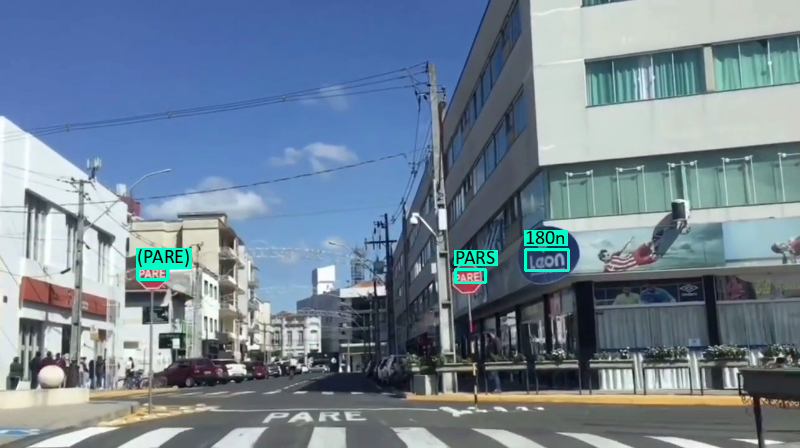

Finished!


In [27]:
from IPython.display import display, clear_output
import PIL.Image

def cv2_imshow(frame):
    """Replacement for Google Colab's cv2_imshow"""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = PIL.Image.fromarray(frame_rgb)
    clear_output(wait=True)
    display(img)

show_frames = 20
current_frame = 0
margin = 4

while True:
  connected, frame = capture.read()

  if not connected:
    break

  frame = cv2.resize(frame, (video_width, video_height))

  image_cp = frame.copy()
  proportion_W, proportion_H, confidences, boxes = EAST_preprocessing(frame, width_EAST, height_EAST, EASTnet, layers_EAST, min_conf_EAST)
  detections = non_max_suppression(np.array(boxes), probs=confidences)
  for (beginX, beginY, endX, endY) in detections:
    beginX = int(beginX * proportion_W)
    beginY = int(beginY * proportion_H)
    endX = int(endX * proportion_W)
    endY = int(endY * proportion_H)
    cv2.rectangle(frame, (beginX, beginY), (endX, endY), (200,255,0), 2)
    roi = image_cp[beginY - margin:endY + margin, beginX - margin:endX + margin]
    
    if roi.size == 0:
      continue
    
    processed_img = pre_processing(roi)
    text = tesseract_OCR(processed_img, config_tesseract)
    # http://www.asciitable.com/
    text = ''.join([c if ord(c) < 128 else '' for c in text]).strip()
    frame = text_background(text, beginX, beginY, frame, font, 20, (200,255,0))
    frame = write_text(text, beginX, beginY, frame, font, (0,0,0), 20)

  if current_frame <= show_frames:
    cv2_imshow(frame)
    current_frame += 1

  output_video.write(frame)

print('Finished!')
output_video.release()

# OCR in videos with EasyOCR

In [28]:
# !pip install easyocr

In [29]:
# !pip uninstall opencv-python-headless
# !pip install opencv-python-headless==4.1.2.30

In [30]:
from easyocr import Reader
import cv2
from matplotlib import pyplot as plt
from PIL import ImageFont, ImageDraw, Image
import numpy as np

In [31]:
languages_list = ['en','pt']
gpu = True
font = 'Fonts/calibri.ttf'

In [32]:
video_file = "Videos/test02.mp4"
cap = cv2.VideoCapture(video_file)

connected, video = cap.read()
video_width = video.shape[1]
video_height = video.shape[0]

In [33]:
video_width, video_height = resize_video(video.shape[1], video.shape[0], 800)
print(video_width, video_height)

800 448


In [34]:
def box_coordinates(box):
  (lt, rt, br, bl) = box
  lt = (int(lt[0]), int(lt[1]))
  rt = (int(rt[0]), int(rt[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))
  return lt, rt, br, bl

In [35]:
def draw_img(img, lt, br, color=(200,255,0),thickness=2):
  cv2.rectangle(img, lt, br, color, thickness)
  return img

In [36]:
name_video_file = 'result_easy_ocr.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(name_video_file, fourcc, fps, (video_width, video_height))

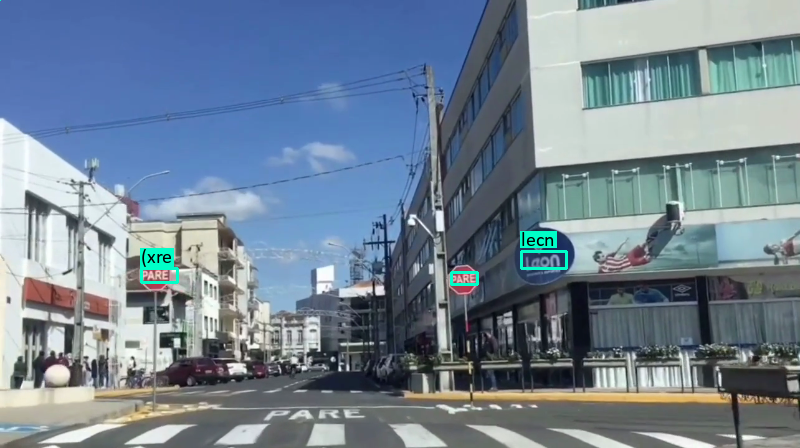

Finished! Processed 103 frames


In [37]:
from IPython.display import display, clear_output
import PIL.Image
import easyocr

# Re-initialize video capture (it was exhausted)
cap = cv2.VideoCapture("Videos/test02.mp4")

# Re-initialize output video
name_video_file = 'result_easy_ocr.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(name_video_file, fourcc, fps, (video_width, video_height))

# Initialize EasyOCR with GPU
reader = easyocr.Reader(['en'], gpu=True)

def easyocr_OCR(img):
    """Replacement for tesseract_OCR using GPU"""
    result = reader.readtext(img, detail=0)
    return ' '.join(result)

show_frames = 20
current_frame = 0
margin = 4

# Check video is ready
print(f"Video opened: {cap.isOpened()}")
print(f"Total frames: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")

while True:
  connected, frame = cap.read()  # Changed from capture to cap
  if not connected:
    break
  frame = cv2.resize(frame, (video_width, video_height))
  image_cp = frame.copy()
  proportion_W, proportion_H, confidences, boxes = EAST_preprocessing(frame, width_EAST, height_EAST, EASTnet, layers_EAST, min_conf_EAST)
  detections = non_max_suppression(np.array(boxes), probs=confidences)
  for (beginX, beginY, endX, endY) in detections:
    beginX = int(beginX * proportion_W)
    beginY = int(beginY * proportion_H)
    endX = int(endX * proportion_W)
    endY = int(endY * proportion_H)
    cv2.rectangle(frame, (beginX, beginY), (endX, endY), (200,255,0), 2)
    
    y1 = max(0, beginY - margin)
    y2 = min(image_cp.shape[0], endY + margin)
    x1 = max(0, beginX - margin)
    x2 = min(image_cp.shape[1], endX + margin)
    roi = image_cp[y1:y2, x1:x2]
    
    if roi.size == 0:
      continue
    
    processed_img = pre_processing(roi)
    text = easyocr_OCR(processed_img)
    text = ''.join([c if ord(c) < 128 else '' for c in text]).strip()
    frame = text_background(text, beginX, beginY, frame, font, 20, (200,255,0))
    frame = write_text(text, beginX, beginY, frame, font, (0,0,0), 20)

  if current_frame <= show_frames and current_frame % 10 == 0:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = PIL.Image.fromarray(frame_rgb)
    clear_output(wait=True)
    display(img)
  
  current_frame += 1
  output_video.write(frame)

print(f'Finished! Processed {current_frame} frames')
output_video.release()
cap.release()